# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [835]:
import pandas as pd
import numpy as np
import seaborn as sn
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
import lightgbm as lgb

In [1029]:
df = pd.read_csv('/datasets/autos.csv') 
# df = pd.read_csv('datasets/autos.csv') 

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [837]:
#name of columns into the snake case 
df.columns = ['date_crawled',  'price', 'vehicle_type', 'registration_year',  'gear_box',  
              'power', 'model', 'kilometer', 'registration_month',  'fuel_type',  'brand',
              'not_repaired',  'date_created',  'number_of_pictures',  'postal_code',  'last_seen'] 

In [838]:
df.drop(['date_crawled', 'last_seen', 'date_created', 'postal_code'], inplace=True, axis=1)

In [839]:
#check for gaps
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gear_box            334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  not_repaired        283215 non-null  object
 11  number_of_pictures  354369 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


In [840]:
#check the duplicates
df.duplicated().sum()

27543

In [841]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326826 non-null  int64 
 1   vehicle_type        291577 non-null  object
 2   registration_year   326826 non-null  int64 
 3   gear_box            309248 non-null  object
 4   power               326826 non-null  int64 
 5   model               308294 non-null  object
 6   kilometer           326826 non-null  int64 
 7   registration_month  326826 non-null  int64 
 8   fuel_type           295704 non-null  object
 9   brand               326826 non-null  object
 10  not_repaired        260399 non-null  object
 11  number_of_pictures  326826 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 29.9+ MB


In [842]:
df.duplicated().sum()

0

replacing NaN in **not_repaired** with no and making it *int*

In [843]:
df.not_repaired.value_counts(dropna=False)

no     225970
NaN     66427
yes     34429
Name: not_repaired, dtype: int64

In [862]:
df.not_repaired.fillna('no', inplace=True)
df.not_repaired = df.not_repaired.astype('category').cat.codes

In [863]:
df.describe()

,price,registration_year,power,kilometer,registration_month,not_repaired
count,323549.000000,323549.000000,323549.000000,323549.000000,323549.000000,323549.000000
mean,4395.779798,2003.147950,107.424452,128541.704657,5.708063,0.105591
std,4507.194697,7.360175,71.373718,37471.198054,3.720300,0.307314
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.000000
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000
75%,6300.000000,2008.000000,141.000000,150000.000000,9.000000,0.000000
max,20000.000000,2019.000000,2000.000000,150000.000000,12.000000,1.000000


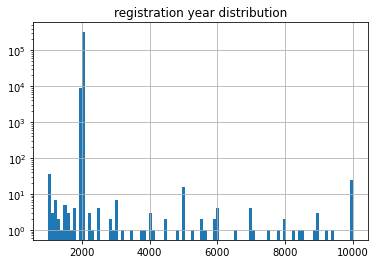

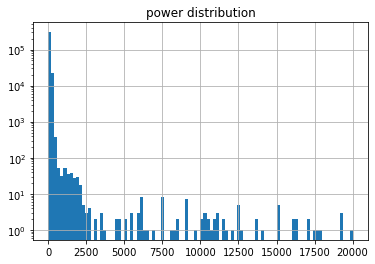

In [846]:
df['registration_year'].hist(bins=100, log=True)
plt.title('registration year distribution')
plt.show()

df['power'].hist(bins=100, log=True)
plt.title('power distribution')
plt.show()

Outliers in *registration_year* should be removed. Let's limit it by 1910-2019

Outliers in *power* should be removed. Let's limit it by 2000 ([link](https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output))

In [847]:
df = df.query('1910<= registration_year <=2019 ')
df = df.query('power <=2000 ')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326546 entries, 0 to 326825
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326546 non-null  int64 
 1   vehicle_type        291477 non-null  object
 2   registration_year   326546 non-null  int64 
 3   gear_box            309106 non-null  object
 4   power               326546 non-null  int64 
 5   model               308098 non-null  object
 6   kilometer           326546 non-null  int64 
 7   registration_month  326546 non-null  int64 
 8   fuel_type           295573 non-null  object
 9   brand               326546 non-null  object
 10  not_repaired        326546 non-null  object
 11  number_of_pictures  326546 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


Price checked, no outliers:

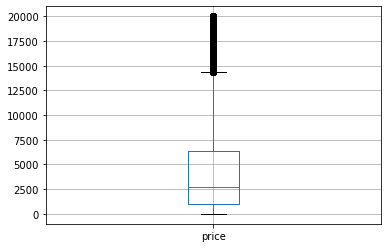

In [848]:
df.boxplot(["price"])
plt.show()

Let's check registration_month coulumn:

Removing **number_of_pictures** column:

In [849]:
df.drop(['number_of_pictures'], inplace=True, axis=1)

In [850]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326546 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326546 non-null  int64 
 1   vehicle_type        291477 non-null  object
 2   registration_year   326546 non-null  int64 
 3   gear_box            309106 non-null  object
 4   power               326546 non-null  int64 
 5   model               308098 non-null  object
 6   kilometer           326546 non-null  int64 
 7   registration_month  326546 non-null  int64 
 8   fuel_type           295573 non-null  object
 9   brand               326546 non-null  object
 10  not_repaired        326546 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB


In [851]:
#filling missing model, vehicle_type, fuel_type,gear_box according to the most frequent values

df.model = df.groupby(['brand', 'registration_year'])['model'].transform(lambda x: 
                                                                         x.fillna((x.mode()[0] if not x.mode().empty else "Unknown")))
df.vehicle_type = df.groupby(['brand', 'model'])['vehicle_type'].transform(lambda x: 
                                                                         x.fillna((x.mode()[0] if not x.mode().empty else "Unknown")))
df.fuel_type = df.groupby(['brand', 'model'])['fuel_type'].transform(lambda x: 
                                                                         x.fillna((x.mode()[0] if not x.mode().empty else "Unknown")))
df.gear_box = df.groupby(['brand', 'model'])['gear_box'].transform(lambda x: 
                                                                         x.fillna((x.mode()[0] if not x.mode().empty else "Unknown")))

In [852]:
df = df.replace('Unknown', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326546 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326546 non-null  int64 
 1   vehicle_type        326543 non-null  object
 2   registration_year   326546 non-null  int64 
 3   gear_box            326542 non-null  object
 4   power               326546 non-null  int64 
 5   model               323549 non-null  object
 6   kilometer           326546 non-null  int64 
 7   registration_month  326546 non-null  int64 
 8   fuel_type           326544 non-null  object
 9   brand               326546 non-null  object
 10  not_repaired        326546 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB


1% of data is nan, we can drop it

In [853]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323549 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               323549 non-null  int64 
 1   vehicle_type        323549 non-null  object
 2   registration_year   323549 non-null  int64 
 3   gear_box            323549 non-null  object
 4   power               323549 non-null  int64 
 5   model               323549 non-null  object
 6   kilometer           323549 non-null  int64 
 7   registration_month  323549 non-null  int64 
 8   fuel_type           323549 non-null  object
 9   brand               323549 non-null  object
 10  not_repaired        323549 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.6+ MB


Correlation matrix


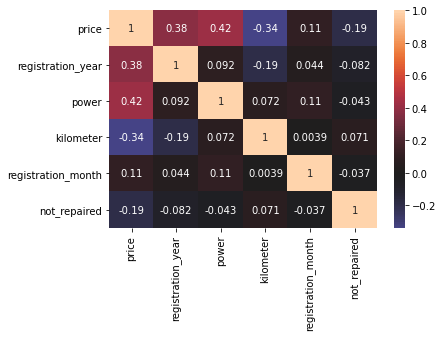

In [864]:
print('Correlation matrix')
sn.heatmap(df.corr(), annot=True, center=0)
plt.show()

No co-dependent features

### Вывод
Изучили датасет с данными по объявлениям о продаже автомобилей. Обработаны пропуски, дубликаты, удалены выбросы.
Колонки **date_crawled, last_seen, date_created, postal_code** удалены как неинформативные.

## Обучение моделей

In [959]:
categorical = ['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand']

target = df['price']

features_encoded = pd.get_dummies(df.drop(['price'], axis=1)) #, drop_first=True
features = df.drop(['price'], axis=1).copy()
features[categorical] = features[categorical].astype('category')  

In [960]:
#splitting the datasets
X_enc_train, X_enc_valid, y_train, y_valid = train_test_split(features_encoded, target, test_size=.25, random_state=25)

X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=.25, random_state=25)

for i in [X_enc_train, y_train, X_enc_valid, y_valid]:
    print(i.shape)

(242661, 311)
(242661,)
(80888, 311)
(80888,)


### Ridge

In [989]:
model = Ridge()

In [993]:
%%time
distributions = dict(alpha=uniform(loc=0, scale=20))
reg = RandomizedSearchCV(model, distributions, random_state=25, scoring='neg_mean_squared_error', cv=2, n_iter=50, n_jobs=7)
search = reg.fit(X_enc_train, y_train)

print(search.best_params_)
print('RMSE:', (-search.best_score_)**.5)

{'alpha': 1.5428063975838402}
RMSE: 2924.777159754573
Wall time: 57.5 s


### Gradient Boosting (LightGBM)

Проверим, как быстро работает LightGBM в зависимости от того, проводилось ли кодирование признаков исходно. Используем значения гиперпараметров по умолчанию.

In [964]:
model = lgb.LGBMRegressor(random_state=25)

In [965]:
starttime = time.time()

model.fit(X_enc_train, y_train, eval_set=(X_enc_valid, y_valid), eval_metric='rmse', verbose=100)

print('Best rmse:\n', model.best_score_['valid_0'])
print(f"Time spent, s:", round(time.time() - starttime, 2))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 1823.76	valid_0's l2: 3.3261e+06
Best rmse:
 OrderedDict([('rmse', 1823.7606072209612), ('l2', 3326102.7524509695)])
Time spent: 1.83 s


In [966]:
starttime = time.time()

model.fit(X_train, y_train, categorical_feature=categorical, eval_set=(X_valid, y_valid), eval_metric='rmse', verbose=100)

time_spent.append(round(time.time() - starttime, 2))
print('Best rmse:\n', model.best_score_['valid_0'])
print(f"Time spent, s:", round(time.time() - starttime, 2))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gear_box', 'model', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	valid_0's rmse: 1768.04	valid_0's l2: 3.12598e+06
Best rmse:
 OrderedDict([('rmse', 1768.0430531626891), ('l2', 3125976.237836844)])
Time spent: 0.56 s


LightGBM c некодированными категориальными признаками работает быстрее в три раза и дает лучшее качество. Будем использовать его для подбора параметров.

In [1027]:
%%time
model = lgb.LGBMRegressor(random_state=25, verbose=0)

distributions = dict(n_estimators=randint(1, 1000), max_depth=randint(1, 15), learning_rate=uniform(loc=0.01, scale=0.1))
reg = RandomizedSearchCV(model, distributions, random_state=25, scoring='neg_mean_squared_error', cv=2, n_iter=50, n_jobs=7)
search = reg.fit(X_train, y_train, categorical_feature=categorical, eval_set=(X_valid, y_valid))

print(search.best_params_)
print('RMSE:', (-search.best_score_)**.5)
print('time for learning with these parameters, s:', 2*round(search.cv_results_['mean_fit_time'][search.best_index_], 2)) 

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gear_box', 'model', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's l2: 1.82114e+07
[2]	valid_0's l2: 1.64735e+07
[3]	valid_0's l2: 1.49628e+07
[4]	valid_0's l2: 1.36468e+07
[5]	valid_0's l2: 1.25125e+07
[6]	valid_0's l2: 1.15096e+07
[7]	valid_0's l2: 1.06469e+07
[8]	valid_0's l2: 9.87884e+06
[9]	valid_0's l2: 9.21539e+06
[10]	valid_0's l2: 8.596e+06
[11]	valid_0's l2: 8.07685e+06
[12]	valid_0's l2: 7.58896e+06
[13]	valid_0's l2: 7

[276]	valid_0's l2: 3.02283e+06
[277]	valid_0's l2: 3.02259e+06
[278]	valid_0's l2: 3.02249e+06
[279]	valid_0's l2: 3.02237e+06
[280]	valid_0's l2: 3.02076e+06
[281]	valid_0's l2: 3.02018e+06
[282]	valid_0's l2: 3.01978e+06
[283]	valid_0's l2: 3.01965e+06
[284]	valid_0's l2: 3.01933e+06
[285]	valid_0's l2: 3.01902e+06
[286]	valid_0's l2: 3.01872e+06
[287]	valid_0's l2: 3.01814e+06
[288]	valid_0's l2: 3.01787e+06
[289]	valid_0's l2: 3.01663e+06
[290]	valid_0's l2: 3.0159e+06
[291]	valid_0's l2: 3.01589e+06
[292]	valid_0's l2: 3.01512e+06
[293]	valid_0's l2: 3.01509e+06
[294]	valid_0's l2: 3.01502e+06
[295]	valid_0's l2: 3.015e+06
[296]	valid_0's l2: 3.01471e+06
[297]	valid_0's l2: 3.01431e+06
[298]	valid_0's l2: 3.01361e+06
[299]	valid_0's l2: 3.01337e+06
[300]	valid_0's l2: 3.01296e+06
[301]	valid_0's l2: 3.0121e+06
[302]	valid_0's l2: 3.01192e+06
[303]	valid_0's l2: 3.01136e+06
[304]	valid_0's l2: 3.01064e+06
[305]	valid_0's l2: 3.01034e+06
[306]	valid_0's l2: 3.00984e+06
[307]	valid_

[544]	valid_0's l2: 2.94761e+06
[545]	valid_0's l2: 2.94731e+06
[546]	valid_0's l2: 2.94724e+06
[547]	valid_0's l2: 2.94699e+06
[548]	valid_0's l2: 2.94676e+06
[549]	valid_0's l2: 2.94676e+06
[550]	valid_0's l2: 2.94646e+06
[551]	valid_0's l2: 2.94663e+06
[552]	valid_0's l2: 2.94639e+06
[553]	valid_0's l2: 2.94648e+06
[554]	valid_0's l2: 2.94636e+06
[555]	valid_0's l2: 2.94607e+06
[556]	valid_0's l2: 2.94597e+06
[557]	valid_0's l2: 2.94553e+06
[558]	valid_0's l2: 2.94532e+06
[559]	valid_0's l2: 2.9452e+06
[560]	valid_0's l2: 2.94496e+06
[561]	valid_0's l2: 2.94481e+06
[562]	valid_0's l2: 2.94474e+06
[563]	valid_0's l2: 2.94466e+06
[564]	valid_0's l2: 2.94475e+06
[565]	valid_0's l2: 2.9447e+06
[566]	valid_0's l2: 2.94478e+06
[567]	valid_0's l2: 2.94453e+06
[568]	valid_0's l2: 2.94439e+06
[569]	valid_0's l2: 2.94409e+06
[570]	valid_0's l2: 2.94367e+06
[571]	valid_0's l2: 2.9435e+06
[572]	valid_0's l2: 2.94347e+06
[573]	valid_0's l2: 2.9437e+06
[574]	valid_0's l2: 2.94392e+06
[575]	valid_

[823]	valid_0's l2: 2.91078e+06
[824]	valid_0's l2: 2.91078e+06
[825]	valid_0's l2: 2.91079e+06
[826]	valid_0's l2: 2.91079e+06
[827]	valid_0's l2: 2.91076e+06
[828]	valid_0's l2: 2.91047e+06
[829]	valid_0's l2: 2.91029e+06
[830]	valid_0's l2: 2.9102e+06
[831]	valid_0's l2: 2.91002e+06
[832]	valid_0's l2: 2.90995e+06
[833]	valid_0's l2: 2.9101e+06
[834]	valid_0's l2: 2.9101e+06
[835]	valid_0's l2: 2.91025e+06
[836]	valid_0's l2: 2.91016e+06
[837]	valid_0's l2: 2.91018e+06
[838]	valid_0's l2: 2.91008e+06
[839]	valid_0's l2: 2.91023e+06
[840]	valid_0's l2: 2.91025e+06
[841]	valid_0's l2: 2.91033e+06
[842]	valid_0's l2: 2.91026e+06
[843]	valid_0's l2: 2.91016e+06
[844]	valid_0's l2: 2.91016e+06
[845]	valid_0's l2: 2.91017e+06
[846]	valid_0's l2: 2.91005e+06
[847]	valid_0's l2: 2.90997e+06
[848]	valid_0's l2: 2.9099e+06
[849]	valid_0's l2: 2.90978e+06
[850]	valid_0's l2: 2.90963e+06
[851]	valid_0's l2: 2.9097e+06
[852]	valid_0's l2: 2.90934e+06
[853]	valid_0's l2: 2.90897e+06
[854]	valid_0

### CatBoost

Проверим, как быстро работает CatBoost в зависимости от того, проводилось ли кодирование признаков исходно. Используем значения гиперпараметров по умолчанию. 

In [979]:
model = CatBoostRegressor(random_state=25, verbose=200, eval_metric='RMSE')

In [980]:
starttime = time.time()

model.fit(X_enc_train, y_train, eval_set=(X_enc_valid, y_valid)) #  X_enc_valid, , y_enc_valid

time_spent.append(round(time.time() - starttime, 2))
print(f"Time spent, s:", round(time.time() - starttime, 2))

Learning rate set to 0.120598
0:	learn: 4173.8058063	test: 4161.9201892	best: 4161.9201892 (0)	total: 72.8ms	remaining: 1m 12s
200:	learn: 1819.8676694	test: 1835.7958142	best: 1835.7958142 (200)	total: 3.46s	remaining: 13.7s
400:	learn: 1747.8158931	test: 1783.7603314	best: 1783.7603314 (400)	total: 6.77s	remaining: 10.1s
600:	learn: 1707.8254480	test: 1761.9391396	best: 1761.9391396 (600)	total: 10s	remaining: 6.67s
800:	learn: 1679.9039265	test: 1748.2618651	best: 1748.2618651 (800)	total: 13.3s	remaining: 3.31s
999:	learn: 1658.2641248	test: 1739.6281133	best: 1739.6281133 (999)	total: 16.5s	remaining: 0us

bestTest = 1739.628113
bestIteration = 999

Time spent: 17.07 s


In [981]:
starttime = time.time()

model.fit(X_train, y_train, cat_features=categorical, eval_set=(X_valid, y_valid))

time_spent.append(round(time.time() - starttime, 2))
print(f"Time spent, s:", round(time.time() - starttime, 2))

Learning rate set to 0.120598
0:	learn: 4173.3525297	test: 4160.4023182	best: 4160.4023182 (0)	total: 132ms	remaining: 2m 11s
200:	learn: 1802.0228172	test: 1815.9898467	best: 1815.9898467 (200)	total: 23.2s	remaining: 1m 32s
400:	learn: 1742.1009034	test: 1775.7823278	best: 1775.7823278 (400)	total: 46.5s	remaining: 1m 9s
600:	learn: 1707.1720559	test: 1756.9675398	best: 1756.9675398 (600)	total: 1m 11s	remaining: 47.2s
800:	learn: 1683.9101790	test: 1747.6099179	best: 1747.6009229 (799)	total: 1m 35s	remaining: 23.7s
999:	learn: 1665.5179791	test: 1739.9195221	best: 1739.9195221 (999)	total: 2m	remaining: 0us

bestTest = 1739.919522
bestIteration = 999

Time spent: 120.72 s


In [982]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

CatBoost c некодированными категориальными признаками работает дольше в 6 раз, и дает аналогичное качество. По этой причине будем использовать модель на предварительно закодированных данных для подбора параметров.

In [986]:
%%time
model = CatBoostRegressor(random_state=25, verbose=0)

distributions = dict(n_estimators=randint(1, 1000), max_depth=randint(1, 15), learning_rate=uniform(loc=0.01, scale=0.1))
reg = RandomizedSearchCV(model, distributions, random_state=25, scoring='neg_mean_squared_error', cv=2, n_iter=50, n_jobs=7)
search = reg.fit(X_enc_train, y_train, eval_set=(X_enc_valid, y_valid))

print(search.best_params_)
print('RMSE:', (-search.best_score_)**.5)
print('time for learning with these parameters, s:', 2*round(search.cv_results_['mean_fit_time'][search.best_index_], 2)) 

{'learning_rate': 0.10120939993482243, 'max_depth': 13, 'n_estimators': 641}
RMSE: 1743.9039171656339
time for learning with these parameters, s: 326.58
Wall time: 18min 13s


### Вывод
Для используемых моделей проводили подбор гиперпараметров путем рандомизации значений. Выяснилось, что для модели Ridge оптимальный параметр alpha=1.54.
Оптимальные гиперпараметры для моделей градиентного бустинга:
- LightGBM: *'learning_rate': 0.07209091874779094, 'max_depth': 14, 'n_estimators': 928*
- CatBoost: *'learning_rate': 0.10120939993482243, 'max_depth': 13, 'n_estimators': 641*

Установлено, что LightGBM c некодированными категориальными признаками работает быстрее в три раза и дает лучшее качество, в то время как первоначальный one-hot encoding делает обучение CatBoost быстрее в 6 раз.

## Анализ моделей

In [989]:
models = [Ridge(alpha=1.54),
         lgb.LGBMRegressor(random_state=25, verbose=200, **{'learning_rate': 0.07209091874779094, 'max_depth': 14, 'n_estimators': 928}),
         CatBoostRegressor(random_state=25, verbose=200, **{'learning_rate': 0.10120939993482243, 'max_depth': 13, 'n_estimators': 641})]

In [1016]:
#arrays to save rmse and duration of fitting
time_spent = []
rmse = []

In [1017]:
model=Ridge(alpha=1.54)

starttime = time.time()
model.fit(X_enc_train, y_train)
time_spent.append(round(time.time() - starttime, 2))
rmse.append(round(mean_squared_error(model.predict(X_enc_valid), y_valid) ** 0.5))

In [1018]:
model = lgb.LGBMRegressor(random_state=25, verbose=200,  **{'learning_rate': 0.07209091874779094, 'max_depth': 14, 'n_estimators': 928})

starttime = time.time()
model.fit(X_train, y_train, categorical_feature=categorical)
time_spent.append(round(time.time() - starttime, 2))
rmse.append(round(mean_squared_error(model.predict(X_valid), y_valid) ** 0.5))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.850832
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.201871
[LightGBM] [Debug] init for col-wise cost 0.006484 seconds, init for row-wise cost 0.009812 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 242661, number of used features: 10
[LightGBM] [Info] Start training from score 4395.355146
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [D

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [

In [1026]:
model = CatBoostRegressor(random_state=25, verbose=0, **{'learning_rate': 0.10120939993482243, 'max_depth': 13, 'n_estimators': 641})

starttime = time.time()
model.fit(X_enc_train, y_train)
time_spent.append(round(time.time() - starttime, 2))
rmse.append(round(mean_squared_error(model.predict(X_enc_valid), y_valid) ** 0.5))

In [1025]:
pd.DataFrame(data={'Learning time, s':time_spent, 'RMSE': rmse}, index=['Ridge', 'LightGBM', 'CatBoost'])

,"Learning time, s",RMSE
Ridge,2.08,2914
LightGBM,4.44,1705
CatBoost,86.07,1706


### Вывод
С подобранными параметрами обучили модели и сравнили времена обучения и качество. Быстрее всего обучается гребенчатая модель, однако качество очень плохое. Среди моделей градиентного бустинга намного быстрее обучается LightGBM (4 с против 86 секунд для catboost), и дает примерно одинаковое качество.  

## Общий вывод
Изучили датасет с данными по объявлениям о продаже автомобилей. Обработаны пропуски, дубликаты, удалены выбросы.

Далее проведен прогноз цены автомобиля на основании его характеристик. Для каждой из модели ML (гребенчатая, LightGBM, CatBoost) подобраны оптимальные параметры для достижения наименьшего значения метрики RMSE.

С подобранными параметрами обучили модели и сравнили времена обучения и качество. Быстрее всего обучается гребенчатая модель, однако качество очень плохое. Среди моделей градиентного бустинга намного быстрее обучается LightGBM (4 с против 86 секунд для catboost), и дает примерно одинаковое качество.  

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей